# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.
  
> Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved.

**Code Block 1 - Infect random subset of people:**  
Function -->  
&nbsp;&nbsp;&nbsp;infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)  
&nbsp;&nbsp;&nbsp;ppl.loc[infected_indices, 'infected'] = True  
Sample size = 100 (1000 * 10%)  
Sampling frame = 1000  
Sampling type = simple random sampling (without replacement)  
Distribution = binomial  
  
**Code Block 2 - Primary contact tracing:**  
Function -->  
&nbsp;&nbsp;&nbsp;ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS  
Sample size = 20 (100 * 20%)  
Sampling frame = 100  
Sampling type = simple random sampling (with replacement, although doesn't really matter for this)  
Distribution = binomial  

  
**Code Block 3 - Secondary contact tracing:**  
Function -->  
&nbsp;&nbsp;&nbsp;event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()  
&nbsp;&nbsp;&nbsp;events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index  
&nbsp;&nbsp;&nbsp;ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True  
Sample size = anywhere from nil (0) to all primary contact traced (20)  
Sampling frame = 20  
Sampling type = convenience  
Distribution = conditional
  


> Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

The 1000 repetition is quite overlapping between the infections vs traced, and over every re-run of the simulation. This is expected as the 1000 repetitions if basically averaging the results over the population many times (actually, as many times as the sample population of this simulation).  
The 10 repetitions look very noisy, both between the re-runs and in overlap between the infections vs traced. Again, to be expected because it's a very small sample of the random simulation, thus any random individual variations can greatly skew the plot at each run.  
Interestingly (for me), the 100 repetitions is not as noisy as I expected. Yes it is noiser than the 1000 repetition, but definitely better than the 10 repetitions...almost like the accuracy is logarithmic (probably not the best word) - in the sense that as you increase your repetitions/n, your noise decreases exponentially. I am not too familiar with stats, but I believe the law of large numbers shows something similar, where as your number of repetitions/n increases, the standard error/noise decreases exponentially (sorry I'm not explaining this well).

> Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The output needs to produce the same output when run multiple times.

I set a random seed (np.random.seed(50)) before the simulation so that all random generators (e.g. np.random.choice & np.random.rand) would have the same start point at each repetition, and carry out their defined "randomness" from there (which is usually systematic leaps). This allows the simulation to run the same sequence and produce the same outcomes every time, removing variability that would come with true randomness (and in turn, improving reproducibility).

## Code

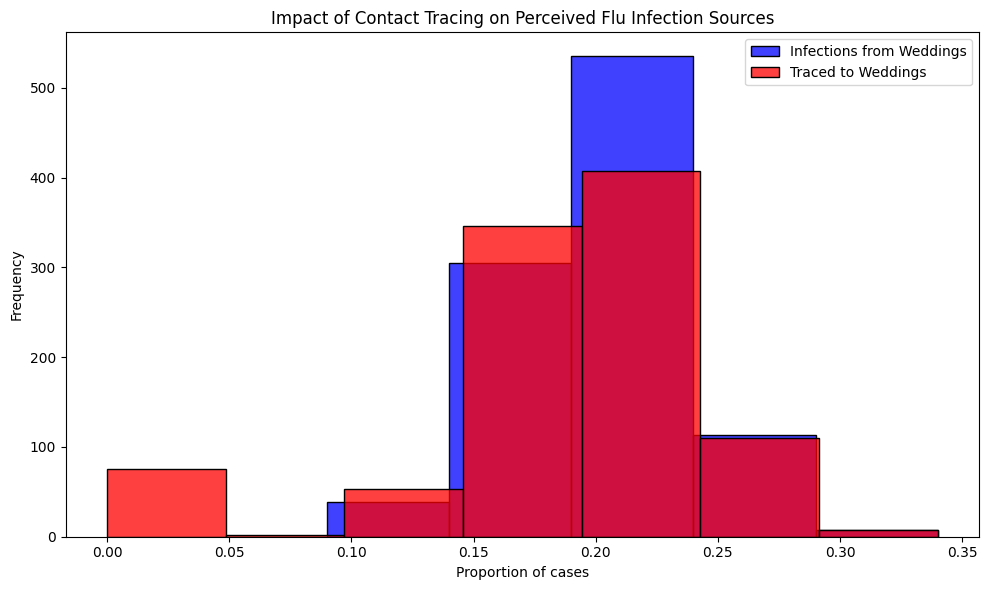

In [30]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

np.random.seed(50) # set random seed to make code reproducible

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)
  ppl.loc[infected_indices, 'infected'] = True

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections)

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b'))
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)

  return p_wedding_infections, p_wedding_traces

# Run the simulation 10 / 100 / 1000 times
results = [simulate_event(m) for m in range(1000)]
props_df = pd.DataFrame(results, columns=["Infections", "Traces"])

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 06 January 2026`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
